In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os


In [7]:
dataset_path = "../data/processed/train_split"

train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(96, 96),   # 🔥 Upgraded size
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(96, 96),
    batch_size=32
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Found 50000 files belonging to 10 classes.
Using 10000 files for validation.
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(96, 96, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [9]:
# Use MobileNetV2's official preprocessing function
preprocess_layer = tf.keras.layers.Lambda(preprocess_input)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [12]:
base_model = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the pretrained backbone

# Build the transfer learning model
inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = preprocess_layer(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

callbacks = [early_stop, lr_schedule]


In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 72ms/step - accuracy: 0.7411 - loss: 0.7427 - val_accuracy: 0.8291 - val_loss: 0.4974 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.7433 - loss: 0.7337 - val_accuracy: 0.8272 - val_loss: 0.5018 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 121s 97ms/step - accuracy: 0.7431 - loss: 0.7368 - val_accuracy: 0.8333 - val_loss: 0.4852 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - accuracy: 0.7462 - loss: 0.7282 - val_accuracy: 0.8407 - val_loss: 0.4579 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - accuracy: 0.7505 - loss: 0.7172 - val_accuracy: 0.8363 - val_loss: 0.4821 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 120ms/step - accuracy: 0.7503 - loss: 0.7107 - val_accuracy: 0.8303 - val_loss: 0.4896 - learning_rate: 0.0010
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step -

In [22]:
# Unfreeze the base model
base_model.trainable = True

# Freeze only early layers to avoid overfitting
fine_tune_at = 100  # You can adjust this
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"✅ Unfroze from layer {fine_tune_at} onwards")


✅ Unfroze from layer 100 onwards


In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # 🔥 Low LR!
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [26]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 200s 156ms/step - accuracy: 0.6400 - loss: 1.2529 - val_accuracy: 0.8467 - val_loss: 0.4576 - learning_rate: 1.0000e-05
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 182s 146ms/step - accuracy: 0.7251 - loss: 0.8648 - val_accuracy: 0.8468 - val_loss: 0.4835 - learning_rate: 1.0000e-05
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 184s 147ms/step - accuracy: 0.7554 - loss: 0.7449 - val_accuracy: 0.8493 - val_loss: 0.4660 - learning_rate: 1.0000e-05
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 183s 147ms/step - accuracy: 0.7718 - loss: 0.6864 - val_accuracy: 0.8546 - val_loss: 0.4470 - learning_rate: 1.0000e-05
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 187s 150ms/step - accuracy: 0.7893 - loss: 0.6313 - val_accuracy: 0.8612 - val_loss: 0.4287 - learning_rate: 1.0000e-05
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 182s 146ms/step - accuracy: 0.8009 - loss: 0.5927 - val_accuracy: 0.8687 - val_loss: 0.4082 - learning_rate: 1.0000e-05
Epoch 7/15
1250/1250 ━━━━━━━

In [28]:
# Combine accuracy and loss from both training phases
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']
epochs_range = range(len(acc))

# Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Full Training: Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Full Training: Loss')
plt.legend()

plt.show()


NameError: name 'history' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get true labels and predictions from validation set
y_true = []
y_pred = []

for images, labels in val_ds.unbatch():
    pred = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(pred))

# Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [ ]:
# Find misclassified examples
import numpy as np

misclassified_images = []
true_labels = []
pred_labels = []

for images, labels in val_ds.unbatch().take(500):  # adjust limit if needed
    pred = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    predicted_label = np.argmax(pred)
    true_label = labels.numpy()

    if predicted_label != true_label:
        misclassified_images.append(images.numpy())
        true_labels.append(true_label)
        pred_labels.append(predicted_label)

    if len(misclassified_images) == 9:
        break

# Plot them
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(misclassified_images[i])
    true_class = class_names[true_labels[i]]
    pred_class = class_names[pred_labels[i]]
    plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis("off")


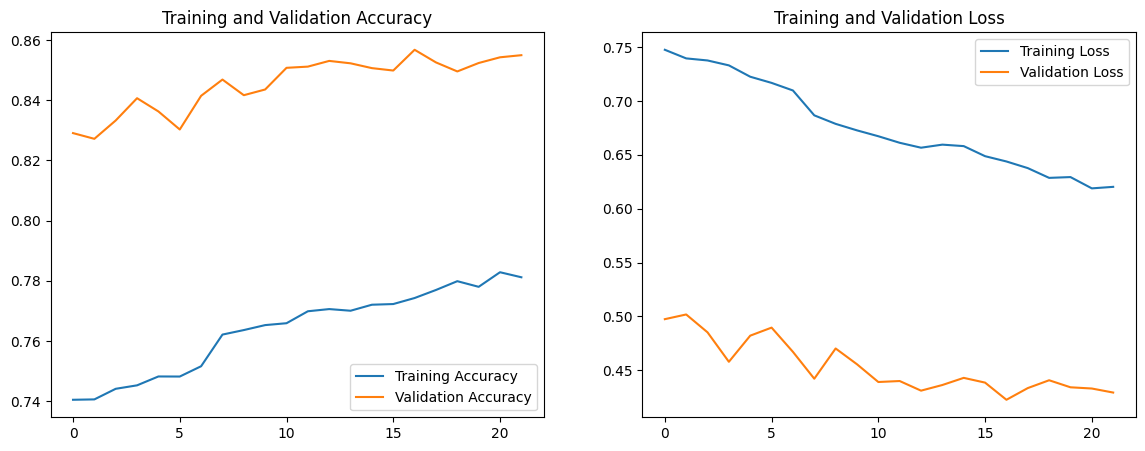

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
# Make sure models/ directory exists
os.makedirs("../models", exist_ok=True)

# Save the fine-tuned model
model.save("../models/mobilenetv2_finetuned.keras")

print("✅ Fine-tuned model saved successfully!")



In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm  # progress bar

# Paths
test_dir = "../data/processed/test"
output_csv_path = "../models/submission.csv"

# Load & sort test files
test_files = sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0]))

# Store predictions
predictions = []

for filename in tqdm(test_files[:300000]):  # limit to 300k in case of junk images
    img_path = os.path.join(test_dir, filename)

    try:
        img = Image.open(img_path).resize((96, 96))  # match model input
        img_array = np.array(img) / 255.0
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
        img_array = img_array.reshape(1, 96, 96, 3)  # add batch dim

        pred = model.predict(img_array, verbose=0)
        predicted_label = class_names[np.argmax(pred)]

        img_id = os.path.splitext(filename)[0]
        predictions.append((img_id, predicted_label))

    except Exception as e:
        print(f"⚠️ Skipping {filename}: {e}")

# Save to CSV
submission_df = pd.DataFrame(predictions, columns=["id", "label"])
submission_df.to_csv(output_csv_path, index=False)
print(f"✅ submission.csv saved to: {output_csv_path}")
